<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/NB1_Exporting_S2_Batch_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Google Earth Engine Image Export </h1>


This notebook can be used to download Sentinel2 300x300 pixels, GeoTiff images from Google Earth Engine (GEE)

Prerequisites:
1. Sign-up for a google earth engine account: https://developers.google.com/earth-engine/#api
2. Free space on a Google Drive account (700 images take about 2GB)
3. ...



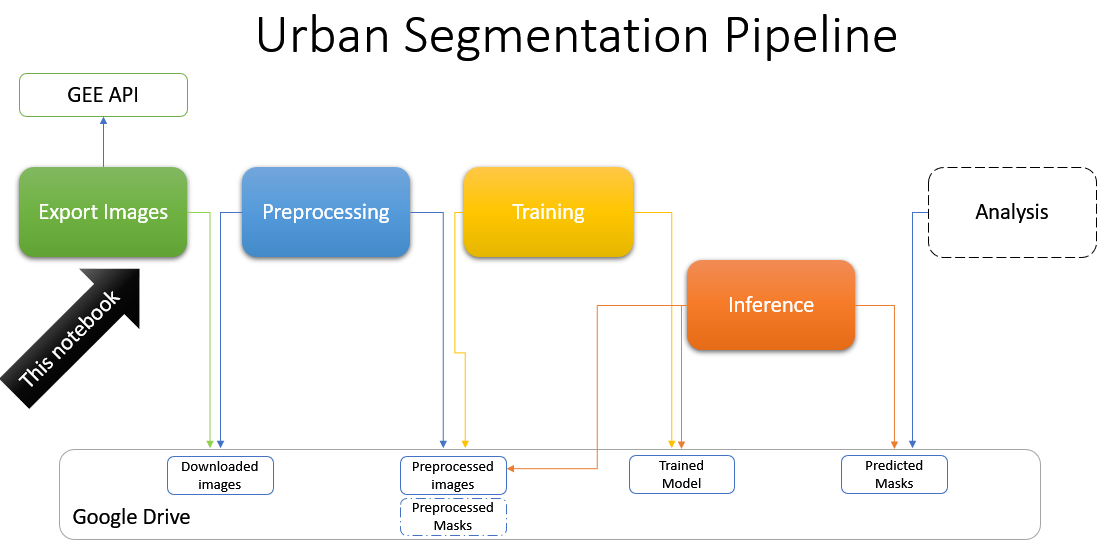

## Setup

- Install the Google Earth Engine Python API and [Rasterio](https://rasterio.readthedocs.io/en/latest/) (access to geospatial raster data)

In [1]:
!pip install earthengine-api rasterio  -q

     |████████████████████████████████| 19.3 MB 4.7 MB/s 


In [33]:
import os
import ee
import numpy as np
import glob as glob
import datetime,random
import rasterio as rio
from tqdm.notebook import tqdm
from rasterio.plot import show_hist,show
ee.__version__

'0.1.317'

- Authenticate to Google Drive (where the downloaded images will be saved)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Authenticate to Earth Engine

1. Click the link below and follow the instructions to get a valid access token 
  - 1.1 Choose a google account, and a Google Earth Engine project (cloud project usually starts with ee-...on the first time, you will not see a project to choose from, then click 'Choose Project' and create a new one...)
  - 1.2 Click 'Generate Token', 'sign in to your google account'
  - 1.3 Click 'Continue' (and **NOT** Back to safety...)
  - 1.4 Mark the 2 checkboxes for permissions and click 'Continue'
  - 1.5 Copy the Authorization Code and paste in the cell output below (then  hit Enter)
  - You should see 'Successfully saved authorization token'
  - (If you don't see this message , run the cell again and repeat the process)

In [6]:
!earthengine authenticate --auth_mode notebook

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=-THXsOpVI4IA3rfSNZmVuJ97EuEQPyGJZ4PueHmDZCs&tc=QWVE8MpNko4n623iXDoLnj6Nc97eZXkhei0Xo7wHreA&cc=RYHp3-UNgQ0Ll5s8686CvjZtjMXVy1GnLMjFmAvf4do

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qhqrd3y_wTqN5V0eBWqZGaHXQb_v6vB7hS3iA_vGfm65_dlBIsTrBI

Successfully saved authorization token.


- Initialize the GEE API

In [7]:
# Earth Engine Python API
ee.Initialize()

## The export function

The following python code is exporting 300x300 pixel GeoTiff images to a google drive folder.
This process creates a task for every image in GEE, and downloads them one by one.

In [14]:
def doExport(dataset,region,img_ID,gee_export_dir,block=True):
  """Runs the image export task.  Block until complete."""
  task = ee.batch.Export.image.toDrive(**{
    'image': dataset.mean(),
    'description': 'Export_S2_Image',
    # 'scale': 10,
    'dimensions': '300x300',
    'region': region['coordinates'],
    'fileNamePrefix':'s2_img_'+str(img_ID),
    'folder':gee_export_dir,
    'crs':'EPSG:3857'
    }
  )
  task.start()

  if(block):
    print('Exporting image to Drive...')
    # Block until the task completes.
    import time
    while task.active():
      time.sleep(5)

    # Error condition
    if task.status()['state'] != 'COMPLETED':
      print('Error with image export (check:https://code.earthengine.google.com/tasks)')
    else:
      print('Image export completed.')
  else:
    return task

## Set the source FeatureCollection

The GEE FeatureCollection defines a list of Geometry Polygons ("Features"), each is going to be scaled down to a 300x300 pixel GeoTiff image, and downloaded to the target folder - the is the downloaded 'region'.

**Note:** the Polygons must be in size 300x300 or larger in order for the scale down process to succeed.

In [11]:
#Set this asset as the source for exporting 300x300 images
# table = ee.FeatureCollection("users/yoavpld/ML/Training_grid")
table = ee.FeatureCollection("users/yoavpld/ML/Saitama_3000m_grid_EPSG6677")

## Set the image collection and export dates

By default the image collection that is used is the "Sentinel2 SR"(https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) - it contains about 1 million images in 2018.

The actual downloaded images 'rectangles' are determined by the FeatureCollection and the data, the 11 Bands of each image, are downloaded from this Image Collection.

The dates are set to 12 months in 2018.

**Note:** by default we take only images that have less than 5% cloud coverage, in order to get maximum clarity, in some cases such data will be missing ('no data') on the images, which may result **black pixels** or even **black images** - such black images are saved as a list and should be handled manually or skipped.

In [12]:
# load the S2 dataset
S2_summer2018 = ee.ImageCollection('COPERNICUS/S2_SR')\
           .filterDate("2018-01-01", "2018-12-31") \
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)); 

# load S2_CLOUD_PROBABILITY dataset
S2_CLOUD_PROBABILITY = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Join S2_summer2018 and S2_CLOUD_PROBABILITY
S2withCloudMask = ee.Join.saveFirst('cloud_mask').apply(
                  S2_summer2018,S2_CLOUD_PROBABILITY,
                  ee.Filter.equals(leftField= 'system:index',rightField= 'system:index')        
                  )
    
S2withCloudMask = ee.ImageCollection(S2withCloudMask)

# # define a function to mask-out clouds from each image
def maskClouds(img):
  clouds = ee.Image(img.get('cloud_mask')).select('probability')
  isNotCloud = clouds.lt(20)
  return img.mask(isNotCloud).divide(10000) #the divide was added by us -see band data value ranges here https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

# # use the maskClouds function
S2_summer2018_cloudsMasked = S2withCloudMask.map(maskClouds)

#Take only specific bands that we use in training
BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
print(len(BANDS),' bands selected')
dataset = S2_summer2018_cloudsMasked.select(BANDS)


11  bands selected


## Create background tasks for image export (on GEE servers)

In [ ]:
%%time
t = datetime.datetime.today()
export_dir='gee_export' + '_'+ t.strftime('%h_%d_%Y_%H%M')
DRIVE_PREFIX='/content/drive/MyDrive/'
!mkdir -p {DRIVE_PREFIX}{export_dir}

tasks = []
# You can uncomment and use this SELECTED list to download only specific images
# SELECTED = [204,480,689,185,528,218,215,509,388,640,543,424,433,66,100,200,300,400]
# SELECTED = [204,66]
print('Exporting images to {} (background)...'.format(export_dir))
features = table.getInfo()['features']
for img in tqdm(features):
  try:
    img_id = img['properties']['ID']
  except:
    img_id = img['properties']['id']
  # print(img)
  geom = img['geometry']
  # You can uncomment and use this SELECTED list to download only specific images
  # if img_id in SELECTED:
  tasks.append(doExport(dataset,geom,img_id,export_dir,block=False))

## Start the export 

**Note:** 700 images take ~2 hours with the free account you can monitor them here: https://code.earthengine.google.com/tasks

In [ ]:
%%time

import time
errs=0
for task in tqdm(tasks):
  while task.active():
    time.sleep(5)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    errs+=1
    print('Error with image export.')
  else:
    # print('Image export completed.')
    pass

print('{} images exported to {}, {} failed.)'.format(len(tasks)-errs,export_dir,errs))

  0%|          | 0/49 [00:00<?, ?it/s]

49 images exported to gee_export_Jul_14_2022_1601, 0 failed.)
CPU times: user 3.96 s, sys: 458 ms, total: 4.42 s
Wall time: 8min 14s


In [ ]:
print('letting drive sync files....')
time.sleep(10)

letting drive sync files....


In [18]:
import os
from pathlib import Path

path = Path(DRIVE_PREFIX+export_dir)
files = [f for f in path.iterdir()]
files[:3]

[PosixPath('/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_2.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_4.tif')]

In [19]:
SAMPLE_IMAGE = Path(files[0])

In [20]:
def normalize(image,vmin=0.0,vmax=0.3):
  '''
  RGB data was exported in the range between 0 and 0.3
  '''
  return (image - vmin)/(vmax-vmin)

def display_image(image_path,bands=[3,2,1],title=None,ax=None,vmin=0.0,vmax=0.3):
  '''
  Displaying RBG images by Red,Green,Blue in this order
  '''
  img =  rio.open(image_path)
  print(img)
  show(normalize(img.read(bands),vmin=vmin,vmax=vmax), title=title,ax=ax)
  # print(title,len(img.indexes),'bands')
  return img

In [21]:
def print_image_metadata(rasterio_img,title=None):
  print(title + ' Metadata:',rasterio_img.meta)
  print(title + ' Transform:\n',rasterio_img.transform)

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_2.tif' mode='r'>


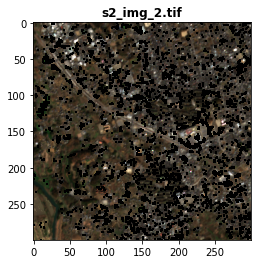

/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_2.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.374845505480964, 0.0, 15533717.641397165,
       0.0, -12.431521972957999, 4297214.347910102)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_2.tif Transform:
 | 12.37, 0.00, 15533717.64|
| 0.00,-12.43, 4297214.35|
| 0.00, 0.00, 1.00|


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif' mode='r'>


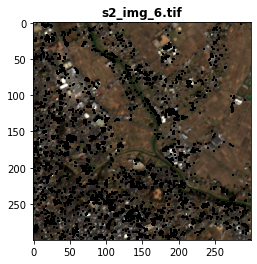

/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.357879731412977, 0.0, 15533761.806325862,
       0.0, -12.414666772155712, 4282346.5335999215)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif Transform:
 | 12.36, 0.00, 15533761.81|
| 0.00,-12.41, 4282346.53|
| 0.00, 0.00, 1.00|


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_4.tif' mode='r'>


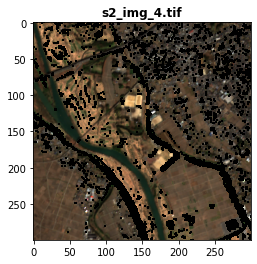

/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_4.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.366348287009945, 0.0, 15533739.7584226,
       0.0, -12.421005204984297, 4289777.620314759)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_4.tif Transform:
 | 12.37, 0.00, 15533739.76|
| 0.00,-12.42, 4289777.62|
| 0.00, 0.00, 1.00|


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_1.tif' mode='r'>


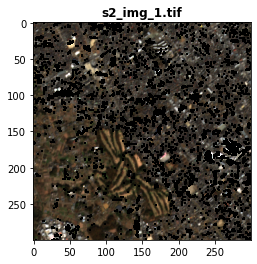

/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_1.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.379094069612522, 0.0, 15533706.569938207,
       0.0, -12.433727354093765, 4300933.988254617)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_1.tif Transform:
 | 12.38, 0.00, 15533706.57|
| 0.00,-12.43, 4300933.99|
| 0.00, 0.00, 1.00|


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_3.tif' mode='r'>


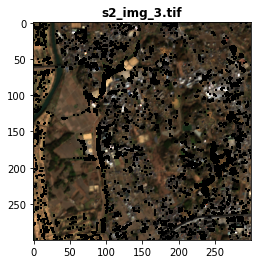

/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_3.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.370596911267688, 0.0, 15533728.704225315,
       0.0, -12.427287858094399, 4293495.361783308)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_3.tif Transform:
 | 12.37, 0.00, 15533728.70|
| 0.00,-12.43, 4293495.36|
| 0.00, 0.00, 1.00|


In [22]:
import matplotlib.pyplot as plt

for i,f in tqdm(enumerate(files[:5])):
  img1=display_image(f,title=f.name)
  print_image_metadata(img1,img1.name)

## Show some downloaded images and its metadata

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif' mode='r'>
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.357879731412977, 0.0, 15533761.806325862,
       0.0, -12.414666772155712, 4282346.5335999215)}
/content/drive/MyDrive/gee_export_Jul_20_2022_1737/s2_img_6.tif Transform:
 | 12.36, 0.00, 15533761.81|
| 0.00,-12.41, 4282346.53|
| 0.00, 0.00, 1.00|


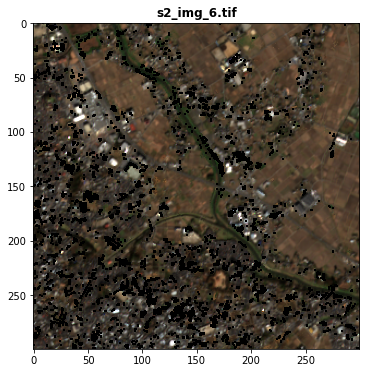

In [26]:
f,axs=plt.subplots(1,1,figsize=(6,6))
NEW_IMG = Path(files[1])
# REF_IMAGE = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_5_428.tif')

# img0=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs[0])
img0=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs)
print_image_metadata(img0,img0.name)

print('===============================')
# img2=display_image(REF_IMAGE,title=REF_IMAGE.name,ax=axs[1])
# print_image_metadata(img2,img2.name)

In [27]:
list_of_files = filter( os.path.isfile,
                        glob.glob(DRIVE_PREFIX+export_dir+'/*.tif', recursive=True) )
# Sort list of files in directory by size 
list_of_files = sorted( list_of_files,
                        key =  lambda x: os.stat(x).st_size)


## 'Black square' images - ('no data') will appear here

You can try to download them manually from the GEE Editor

In [28]:
print('nan exported files (size 29KB):')
!mkdir -p {export_dir}_failed
for file in list_of_files[:30]:
  fsize=os.stat(file).st_size
  if(fsize==29262):
    print(file,fsize)
    shutil.move(file, export_dir +'_failed')

print('Any failed exported images were moved to:',export_dir +'_failed')

nan exported files (size 29KB):
Any failed exported images were moved to: gee_export_Jul_20_2022_1737_failed


In [37]:
#Images can be read as numpy arrays
# np.array(img0.read(1)),np.array(img2.read(1))
np.array(img0.read(1))


array([[0.0864 , 0.12515, 0.13705, ..., 0.0493 , 0.0384 ,     nan],
       [0.1297 , 0.2039 , 0.2184 , ..., 0.05425, 0.05375, 0.0332 ],
       [0.10565, 0.147  , 0.13185, ..., 0.06045, 0.05385, 0.0315 ],
       ...,
       [0.08595, 0.0599 , 0.0476 , ..., 0.0664 , 0.0965 , 0.0641 ],
       [0.0695 , 0.0461 , 0.04395, ..., 0.0615 , 0.09735, 0.0485 ],
       [0.05475, 0.0418 , 0.04965, ...,     nan,     nan, 0.0365 ]],
      dtype=float32)

## For DEBUG - Zooming in on a single image end2end

In [38]:
# from pprint import pprint
# for fff in table.getInfo()['features']:
#   if (fff['properties']['id']==1):
#     pprint(fff)

In [39]:
# f,axs=plt.subplots(1,3,figsize=(15,6))
# # IMG_01 = 's2_img_1.tif'
# IMG_01 = 's2_img_19.tif'
# downloaded_img1 = Path('/content/drive/MyDrive/gee_export_Jul_14_2022_1601/'+IMG_01)
# preprocessed_img1 = Path('/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/'+IMG_01)
# pred_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul18/pred_'+IMG_01)

# d_img_01=display_image(downloaded_img1,title=downloaded_img1.name,ax=axs[0])
# print_image_metadata(d_img_01,d_img_01.name)
# print('===============================')
# p_img_01=display_image(preprocessed_img1,title=preprocessed_img1.name,ax=axs[1])
# print_image_metadata(p_img_01,p_img_01.name)
# print('===============================')
# p_msk_01=display_image(pred_mask1,title=pred_mask1.name,ax=axs[2],bands=[1])
# print_image_metadata(p_msk_01,p_msk_01.name)
# assert(p_img_01.meta['transform']==p_msk_01.meta['transform'])
# assert(p_img_01.meta['crs']==p_msk_01.meta['crs'])

## 2 good ones from Test Preds

In [40]:
# f,axs=plt.subplots(1,4,figsize=(15,6))
# IMG_011 = 'R_1_88.tif'
# downloaded_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/'+IMG_011)
# preprocessed_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/'+IMG_011)
# orig_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test/ESM_88.tif')
# pred_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/esm_preds_jul18/pred_'+IMG_011)

# d_img_01=display_image(downloaded_img1,title=downloaded_img1.name,ax=axs[0])
# print_image_metadata(d_img_01,d_img_01.name)
# print('===============================')
# p_img_01=display_image(preprocessed_img1,title=preprocessed_img1.name,ax=axs[1])
# print_image_metadata(p_img_01,p_img_01.name)
# print('===============================')
# o_msk_01=display_image(orig_mask1,title=orig_mask1.name,ax=axs[2],bands=[1])
# print_image_metadata(o_msk_01,o_msk_01.name)
# print('===============================')
# p_msk_01=display_image(pred_mask1,title=pred_mask1.name,ax=axs[3],bands=[1])
# print_image_metadata(p_msk_01,p_msk_01.name)
# assert(p_img_01.meta['transform']==p_msk_01.meta['transform'])
# assert(p_img_01.meta['crs']==p_msk_01.meta['crs'])
# assert(o_msk_01.meta==p_msk_01.meta)